In [125]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [126]:
# 트레인셋
train = pd.read_csv('train.csv', index_col=False,)
X_train = train.loc[:,'X00':'X39']
y_train = train.loc[:,'Y00':'Y17']

In [127]:
# 테스트 셋
test = pd.read_csv('test.csv', index_col=False,)
test=test.drop(['id'], axis=1)

EDA - 연관성 떨어지는 데이터 제거

1. 온도센서

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

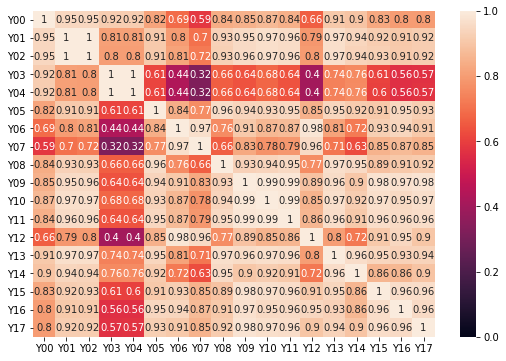

In [52]:
# 연관성이 떨어지는 부분은 짙은 음영
plt.figure(figsize=(9, 6))
sns.heatmap(y_train.corr(), vmin=0, vmax=1, annot=True)

In [128]:
# y03, 04 제거
# 칼럼 드랍할때는 train과 test 둘다에 처리해줘야 함
train = train.drop(['Y03', 'Y04'], axis=1)
#test.drop(['Y03', '04'], axis=1)

2. 기온

[참고자료](https://dacon.io/competitions/official/235584/codeshare/716?page=1&dtype=recent)

In [65]:
def kde_plot(col_group):
    for col in col_group:
        sns.kdeplot(train[col], kernel='epa')
    plt.show()

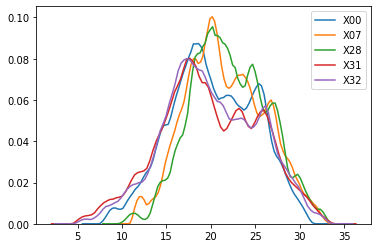

In [66]:
group_1 = ['X00', 'X07', 'X28', 'X31', 'X32']
kde_plot(group_1)

In [69]:
# 대체로 비슷한 분포

3. 기압

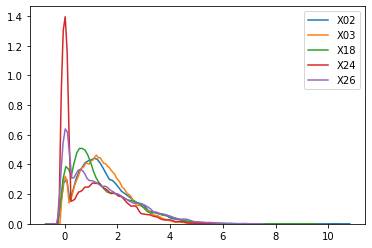

In [71]:
group_2 = ['X02', 'X03', 'X18', 'X24', 'X26']
kde_plot(group_2)

In [93]:
#특이변수 X24제거
# 칼럼 드랍할때는 train과 test 둘다에 처리해줘야 함
train = train = train.drop(['X24'], axis=1)
teat = test = test.drop(['X24'], axis=1)

4. 풍속

In [76]:
def show_plot(col_group):
    plt.plot(train[col_group])
    plt.show()
    sns.boxplot(x='variable', y='value', data=pd.melt(train[col_group]))
    plt.show()

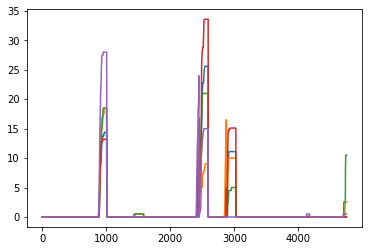

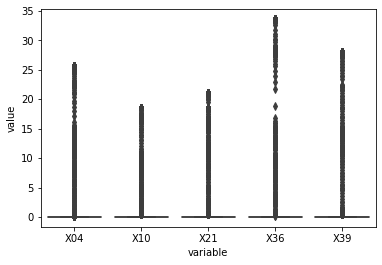

In [77]:
group_3 = ['X04', 'X10', 'X21', 'X36', 'X39']
show_plot(group_3)

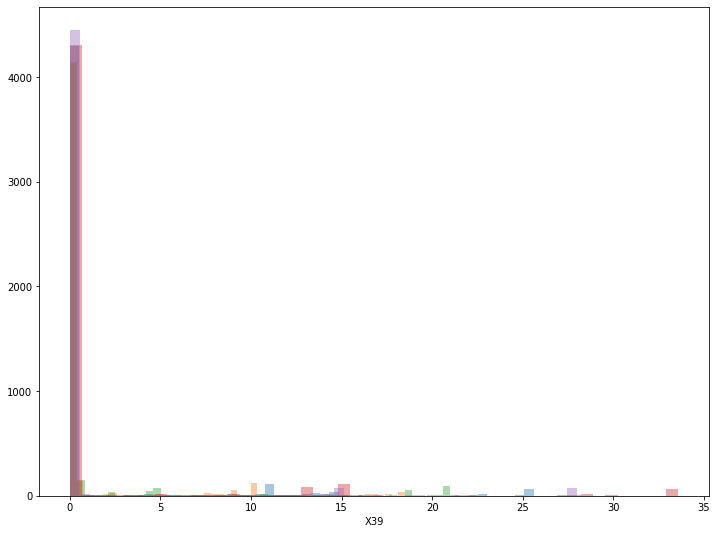

In [82]:
plt.figure(figsize=(12, 9))
for col in group_3:
    sns.distplot(train[col], kde=False)
plt.show()

In [80]:
#비슷한 양상 추가제거 안함

5. 강수량 6. 기압 7. 일사량 

In [81]:
#비슷한 양상 추가제거 안함 생략

8. 습도

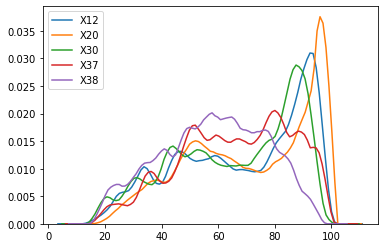

In [83]:
group_7 = ['X12', 'X20', 'X30', 'X37', 'X38']
kde_plot(group_7)

In [84]:
#비슷한 양상 추가제거 안함 생략

모델 재학습

In [129]:
X_train = train.loc[:,'X00':'X39']
y_train = train.loc[:,'Y00':'Y17']

In [130]:
# nan 값 제거
y = y_train.dropna()
y.shape

(4320, 16)

In [131]:
# 트레인 셋 범주 조정
X = X_train.loc[:y.shape[0]-1,:]
X.shape

(4320, 40)

In [132]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping

K.clear_session()
model = Sequential() # Sequeatial Model
model.add(LSTM(20, input_shape=(X.shape[1], 1))) # 트레인값
model.add(Dense(y.shape[1])) # 출력값
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20)                1760      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                336       
Total params: 2,096
Trainable params: 2,096
Non-trainable params: 0
_________________________________________________________________


In [133]:
X = X.values
X = X.reshape(X.shape[0], X.shape[1], 1)

In [146]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

model.fit(X, y, epochs=10000,
          batch_size=30, verbose=1, callbacks=[early_stop])

Epoch 1/10000
432/432 [==============================] - ETA: 0s - loss: 6.676 - ETA: 0s - loss: 10.61 - ETA: 0s - loss: 10.33 - ETA: 0s - loss: 11.53 - ETA: 0s - loss: 13.44 - ETA: 0s - loss: 13.53 - 0s 790us/step - loss: 13.2959
Epoch 2/10000
432/432 [==============================] - ETA: 0s - loss: 11.15 - ETA: 0s - loss: 12.68 - ETA: 0s - loss: 14.07 - ETA: 0s - loss: 13.21 - ETA: 0s - loss: 14.14 - 0s 760us/step - loss: 13.0134
Epoch 3/10000
432/432 [==============================] - ETA: 0s - loss: 12.54 - ETA: 0s - loss: 11.06 - ETA: 0s - loss: 13.17 - ETA: 0s - loss: 12.56 - ETA: 0s - loss: 12.95 - 0s 764us/step - loss: 12.8078
Epoch 4/10000
432/432 [==============================] - ETA: 0s - loss: 11.47 - ETA: 0s - loss: 12.32 - ETA: 0s - loss: 13.11 - ETA: 0s - loss: 12.70 - ETA: 0s - loss: 12.83 - ETA: 0s - loss: 12.34 - ETA: 0s - loss: 13.01 - 0s 1ms/step - loss: 12.6900
Epoch 5/10000
432/432 [==============================] - ETA: 0s - loss: 8.422 - ETA: 0s - loss: 9.452

In [135]:
#모델 저장
import joblib
joblib.dump(model, 'model_EDA_result_1.pkl')

['model_EDA_result_1.pkl']

In [136]:
# 모델 적용 함수
def model_fit_1(data, model_name, file_name):
    model = joblib.load(str(model_name)) 
    data_r = data.values.reshape(data.shape[0],data.shape[1],1 )
    pred_out=model.predict(data_r)
    df = pd.DataFrame(pred_out)
    df.to_csv(str(file_name), index = False, header = False)
    return df

In [137]:
#지난 3일간의 데이터셋
X_test = X_train.loc[y.shape[0]:,:]

In [138]:
X_test.shape

(432, 40)

In [139]:
#지난3일간의 y값 연산
pred_out = model_fit_1(X_test, 'model_EDA_result_1.pkl', 'pred_out_EDA_reault_1.csv')

모델링 2차

In [140]:
X=pd.concat([X_test.reset_index(drop=True), pred_out.reset_index(drop=True)], axis=1)

In [141]:
y = train['Y18']
y = y.dropna()
y.shape

(432,)

In [142]:
K.clear_session()
model = Sequential() # Sequeatial Model
model.add(LSTM(20, input_shape=(X.shape[1], 1))) # (timestep, feature)
model.add(Dense(1)) # output = 1
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20)                1760      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


In [143]:
X = X.values
X = X.reshape(X.shape[0], 55, 1)
# 피처 40(-1)+18(-2) = 55

In [147]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

model.fit(X, y, epochs=10000,
          batch_size=30, verbose=1, callbacks=[early_stop])

Epoch 1/10000
432/432 [==============================] - ETA: 0s - loss: 10.53 - ETA: 0s - loss: 12.73 - ETA: 0s - loss: 12.90 - ETA: 0s - loss: 11.21 - ETA: 0s - loss: 12.21 - ETA: 0s - loss: 12.15 - 0s 801us/step - loss: 12.0000
Epoch 2/10000
432/432 [==============================] - ETA: 0s - loss: 6.688 - ETA: 0s - loss: 11.01 - ETA: 0s - loss: 11.59 - ETA: 0s - loss: 12.26 - ETA: 0s - loss: 11.54 - 0s 743us/step - loss: 12.0513
Epoch 00002: early stopping


In [148]:
joblib.dump(model, 'model_EDA_result_2.pkl')

['model_EDA_result_2.pkl']

In [149]:
# 모델2 적용 함수
def model_fit_2(data1, data2, model_name, file_name):
    data=pd.concat([data1.reset_index(drop=True), data2.reset_index(drop=True)], axis=1)
    model = joblib.load(str(model_name))
    data_r = data.values.reshape(data.shape[0],data.shape[1],1 )
    pred_out=model.predict(data_r)
    df = pd.DataFrame({'id':range(144*33, 144*113),
              'Y18':pred_out.reshape(1,-1)[0]})
    df.to_csv(file_name, index = False)
    return df

테스트

In [150]:
pred_out_1 = model_fit_1(test, 'model_EDA_result_1.pkl', 'pred_out_1.csv')

In [151]:
pred_out_fin = model_fit_2(test, pred_out_1, 'model_EDA_result_2.pkl', 'pred_out_fin.csv')

In [124]:
 # 297 지현 SCORE 8.84763 -> 기존 12점에 비해 약 4점 향상